In [1]:
import pandas as pd
import numpy as np
import plotly.offline as plt
import plotly.graph_objs as go
#import os
import random
import math
from tqdm import tqdm


In [2]:
Songs = pd.read_csv("songs.csv")
songs = Songs.set_index('Title')
songs

,(1980s),(1990s),(2000s),(2010s),(2020s),Pop,Rock,Counrty,Folk,Dance,...,Love,Metal,Classic,Funk,Electric,Acoustic,Indie,Jazz,SoundTrack,Rap
Title,,,,,,,,,,,,,,,,,,,,,
The Scientist,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yellow,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Stairway to Heaven,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shape of You,0,0,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
Fix You,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Forgotten,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Lebanese Blonde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Rocket Man (I Think It's Going to Be a Long Long Time),1,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [3]:
NFEATURE = 21 #Number of Features
S = 50 #Hyper Parameter
totReco = 0 #Number of total recommendation till now
startConstant = 5 #for low penalty in starting phase

In [4]:
ratedSongs = set()

In [5]:
def compute_utility(user_features, song_features, epoch, s=S):
    """ Compute utility U based on user preferences and song preferences """
    user_features = user_features.copy()
    song_features = song_features.copy()
    dot = user_features.dot(song_features)
    ee = (1.0 - 1.0*math.exp(-1.0*epoch/s))
    res = dot * ee
    return res

In [6]:
def get_song_features(song):
    """ Feature of particular song """
    if isinstance(song, pd.Series):
        return song[-NFEATURE:]
    elif isinstance(song, pd.DataFrame):
        return get_song_features(pd.Series(song.loc[song.index[0]]))
    else:
        raise TypeError("{} should be a Series or DataFrame".format(song))

In [7]:
def best_recommendation(user_features, epoch, s):
    global Songs
    Songs = Songs.copy()
    """ Song with highest utility """
    utilities = np.zeros(Songs.shape[0])
    
    for i, (Title, song) in enumerate(Songs.iterrows()):
        song_features = get_song_features(song)
        utilities[i] = compute_utility(user_features, song_features, epoch - song.last_t, s)
    return Songs[Songs.index == Songs.index[argmax(utilities)]]

In [8]:
def argmax(q_values):
    
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i] > top:
            top, ties = q_values[i], [i]
        elif q_values[i] == top:
            ties.append(i)
    ind = np.random.choice(ties)
    
    return ind

In [9]:
def all_recommendation(user_features):
    """ Top 10 songs with using exploration and exploitation """
    global Songs
    Songs = Songs.copy()
    i=0
    recoSongs = []
    while i < 10:
        song = greedy_choice_no_t(user_features, totReco, S)
        recoSongs.append(song)
        Songs.loc[Songs.index.isin(song.index),'last_t'] = totReco
        i += 1
    return recoSongs

In [10]:
def random_choice():
    """ Random songs which aren't been rated yet """
    global Songs
    Songs = Songs.copy()
    song = Songs.sample()
    while(song.index[0] in ratedSongs):
        song = Songs.sample()
    return song

In [11]:
def greedy_choice(user_features, epoch, s):
    """ greedy approach to the problem """
    global totReco
    epsilon = 1 / math.sqrt(epoch+1)
    totReco = totReco + 1
    if random.random() > epsilon: # choose the best
        return best_recommendation(user_features, epoch, s)
    else:
        return random_choice()

In [12]:
def greedy_choice_no_t(user_features, epoch, s, epsilon=0.3):
    """ greedy approach to the problem. After some iteration value of epsilon will be constant """
    global totReco
    totReco = totReco + 1
    if random.random() > epsilon: # choose the best
        return best_recommendation(user_features, epoch, s)
    else:
        return random_choice()

In [13]:
def iterative_mean(old, new, t):
    """ Compute the new mean, Added startConstant for low penalty in starting phase """
    t += startConstant
    return ((t-1) / t) * old + (1/t) * new

In [14]:
def update_features(user_features, song_features, rating, t):
    return iterative_mean(user_features, song_features * rating, 1.0*float(t)+1.0)

In [15]:
def actionAndReward():
    act = input("Do you want to skip this song ? (y/n) :")
    if act == "y" :
        reward = -5
        action = 0
    if act == "n" :

        reward = 1
        action = 1

    return reward , action

In [16]:
score=[]
def reinforcement_learning(s=200, N=5):
    global Songs
    Songs = Songs.copy()

    user_features = np.zeros(NFEATURE)
    print("Select song features that you like")
    Features = ["1980s", "1990s", "2000s", "2010s", "2020s", "Pop", "Rock", "Country", "Folk", "Dance", "Grunge", "Love", "Metal", "Classic", "Funk", "Electric", "Acoustic", "Indie", "Jazz", "SoundTrack", "Rap"];
    for i in range (0,len(Features)):
        print (str(i+1) + ". " + Features[i])
    choice = "y"
    likedFeat = set()
    while (choice.lower().strip() == "y"):
        num = input("Enter number associated with feature: ")
        likedFeat.add(Features[int(num)-1])
        choice=input("Do you want to add another feature? (y/n) ");
    for i in range (0,len(Features)):
        if(Features[i] in likedFeat):
            user_features[i] = 1.0/len(likedFeat)
    
    print("\n\nRate following " + str(N) + " songs. So that we can know your taste.\n")
    for t in range(N):
        if(t>=10):
            recommendation = greedy_choice_no_t(user_features, t+1, s, 0.3)
        else:
            recommendation = greedy_choice(user_features, t+1, s)
        recommendation_features = get_song_features(recommendation)
        reco = recommendation.index[0]
        print(Songs['Title'].loc[reco])
        reward,action = actionAndReward()
        if action == 1 :
            user_rating = input('How much do you like the song(1-10): ')
            user_rating = int(user_rating)
            user_rating = 1.0*user_rating/10.0
            user_features = update_features(user_features, recommendation_features, user_rating, t)
            utility = compute_utility(user_features, recommendation_features, t, s)
            Songs.loc[Songs.index.isin(recommendation.index),'last_t'] = t+1
            ratedSongs.add(recommendation.index[0])
            score.append(reward)
        else :
            user_rating = 0
            user_features = update_features(user_features, recommendation_features, user_rating, t)
            utility = compute_utility(user_features, recommendation_features, t, s)
            Songs.loc[Songs.index.isin(recommendation.index),'last_t'] = t+1
            ratedSongs.add(recommendation.index[0])
            score.append(reward)
    
    return user_features , score

In [17]:
#removing votes and rating column from dataframe
arr = []
for i in range(Songs.shape[0]):
    arr.append(-S)
arr = np.array(arr)
Songs.insert(0, 'last_t', arr)

user_features,score = reinforcement_learning()


Select song features that you like
1. 1980s
2. 1990s
3. 2000s
4. 2010s
5. 2020s
6. Pop
7. Rock
8. Country
9. Folk
10. Dance
11. Grunge
12. Love
13. Metal
14. Classic
15. Funk
16. Electric
17. Acoustic
18. Indie
19. Jazz
20. SoundTrack
21. Rap
Enter number associated with feature: 3
Do you want to add another feature? (y/n) y
Enter number associated with feature: 19
Do you want to add another feature? (y/n) y
Enter number associated with feature: 5
Do you want to add another feature? (y/n) n


Rate following 5 songs. So that we can know your taste.

Go Your Own Way
Do you want to skip this song ? (y/n) :y
Retrograde
Do you want to skip this song ? (y/n) :n
How much do you like the song(1-10): 7
Hymn For The Weekend - Seeb Remix
Do you want to skip this song ? (y/n) :n
How much do you like the song(1-10): 5
I Feel It Coming
Do you want to skip this song ? (y/n) :y
Safe and Sound
Do you want to skip this song ? (y/n) :n
How much do you like the song(1-10): 2


In [19]:
#UI
choice = "y"
while choice == "y":
    print("\nWait \n\n")
    recommendation = all_recommendation(user_features)
    
    print("\n\nRate songs one by one or leave it blank")
    for music in recommendation:
        if(music.index[0] in ratedSongs):
            print("Song already rated")
            continue
        print(Songs['Title'].loc[music.index[0]])
        reward,action = actionAndReward()
        if action == 1 :
            inn = input("Rate it (1/10): ")
            if(inn.strip() != ""):
                ratedSongs.add(music.index[0])
                song_features = get_song_features(music)
                user_features = update_features(user_features, song_features, int(inn), totReco)
                score.append(reward+int(inn)/10)
        if action == 0 :
            inn = "0"
            if(inn.strip() != ""):
                ratedSongs.add(music.index[0])
                song_features = get_song_features(music)
                user_features = update_features(user_features, song_features, int(inn), totReco)
                score.append(reward) 
        
    
    choice = input("\nDo you want more recommendations? (y/n) ").strip()


Wait 




Rate songs one by one or leave it blank
The Greatest
Do you want to skip this song ? (y/n) :y
Tenerife Sea
Do you want to skip this song ? (y/n) :n
Rate it (1/10): 4
Way Down We Go
Do you want to skip this song ? (y/n) :n
Rate it (1/10): 8
That's What I Like
Do you want to skip this song ? (y/n) :y
Mountain At My Gates
Do you want to skip this song ? (y/n) :y
Cool Girl
Do you want to skip this song ? (y/n) :n
Rate it (1/10): 9
White Room
Do you want to skip this song ? (y/n) :y
One
Do you want to skip this song ? (y/n) :y
Water Under The Bridge
Do you want to skip this song ? (y/n) :n
Rate it (1/10): 5
Give Life Back to Music
Do you want to skip this song ? (y/n) :y

Do you want more recommendations? (y/n) n


In [20]:
user_features

(1980s)            0.0
(1990s)            0.0
(2000s)       0.525332
(2010s)            0.0
(2020s)       0.936054
Pop           0.425132
Rock               0.0
Counrty            0.0
Folk               0.0
Dance              0.0
Grunge             0.0
Love           0.09926
Metal              0.0
Classic            0.0
Funk               0.0
Electric      0.511584
Acoustic           0.0
Indie         0.205138
Jazz          0.120073
SoundTrack         0.0
Rap                0.0
dtype: object

<AxesSubplot:>

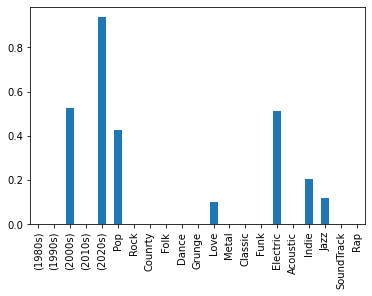

In [21]:
user_features.plot.bar(x=user_features[0], y=user_features[1], rot=90)

100%|██████████| 9000000/9000000 [00:03<00:00, 2529796.03it/s]


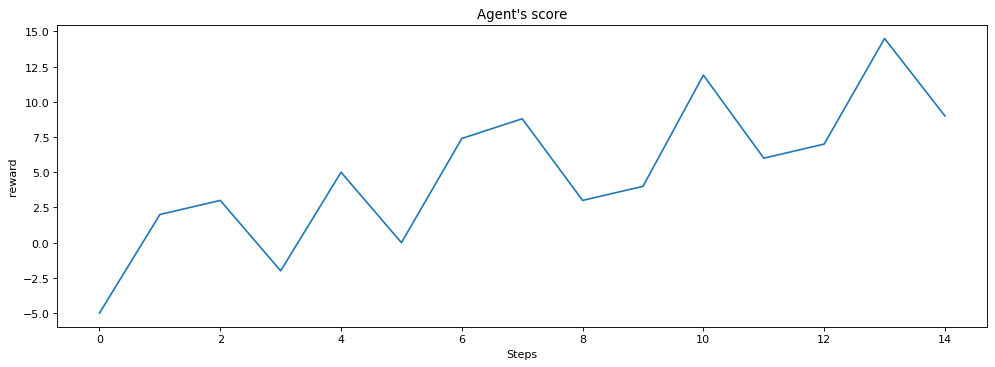

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
averages=[]
for i in range(len(score)) :
    averages.append(score[i] / 1+i)
for i in tqdm(range(int(9e6))): 
    pass
plt.plot(averages )
plt.title("Agent's score")
plt.xlabel("Steps")
plt.ylabel("reward")
plt.show()